In [27]:
import gensim
import pandas as pd
import numpy as np
from pymorphy2 import MorphAnalyzer
import pyLDAvis.gensim_models
from collections import Counter
from string import punctuation
from razdel import tokenize as razdel_tokenize
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.decomposition import TruncatedSVD, NMF, PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
morph = MorphAnalyzer()
warnings.filterwarnings("ignore") 

На одном из прошлых занятий мы научились представлять тексты в виде векторов методом мешка слов. Мы векторизовали тексты с помощью CountVectorizer/TfidfVectorizer, которые выдают большие разреженные вектора. Для них даже есть специальная структура данных, которая позволяет хранить такие вектора в памяти. Не все алгоритмы даже в sklearn умеют работать с этой структурой данных. Привести ее к обычному np.array можно, но в большинстве случаев такая матрица просто не поместится в память компьютера. Чтобы обойти это ограничение можно воспользоваться методами снижения размерности, в частности матричными разложениями.

# Матричные разложения 

Матричные разложения - это представление матрицы в виде произведения нескольких других матриц. Есть достаточно много алгоритмов для разложения матриц и у каждого из них свои свойства и области применения. В семинаре мы посмотрим на два разложения SVD и NMF. Нам не очень интересно в рамках NLP, как они устроены с математической точки зрения. Важнее понять, какие у них свойства и как их можно применять.  

### SVD

SVD (Singular value decomposition) или сингулярное разложение - это представление матрицы в виде произведения трех специальных матриц (о том, что в них специального можно почитать [тут](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BD%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D0%B7%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5), для семинара это не важно)

SVD один из центральных алгоритмов в линейной алгебре. Схематически можно изобразить его вот так.

In [120]:
Image(url="https://gcdn.pbrd.co/images/ocY2MVS78b3W.png", retina=True,
     width=1000, height=900)

У SVD есть также приблезительная реализация - TruncatedSVD. В SVD в средней диагональной матрице значения отсортированы по значимости и можно взять только ток-K самых значимых компонент. Тогда разложение будет выглядеть как-то так (обратите внимание на размерности)

In [122]:
Image(url="https://gcdn.pbrd.co/images/YcZxyZhQGrUC.png?o=1",
     width=1000, height=900)


K как правило сильно ниже размера словаря и поэтому используя матрицу U вместо оригинальной мы сильно уменьшаем размерность.

### NMF

NMF (Non-negative matrix factorization) или неотрицательное матричное разложение - это представление матрицы в виде произведения двух матриц, значения в которых больше или равны 0. 

In [125]:
Image(url="https://gcdn.pbrd.co/images/jQVHA0PXy50z.png",
     width=1000, height=900)

В NMF параметр K нужно задать заранее, под него будут подбираться две матрицы. Как правило, чем выше K, тем лучше будет приблежаться изначальная матрица. Но при этом будет увеличиваться потребление памяти и время схождения.

Давайте попробуем понизить размерности с помощью этих алгоритмов. 

В этот раз используем данные объявлений на Авито. По описанию нужно предсказать категорию товара. Данные взяты из этого соревнования - https://www.kaggle.com/c/avito-demand-prediction (в семинаре использована лишь небольшой процент всех данных соревнования)

In [5]:
# добавим лемматизацию
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)



In [6]:
data = pd.read_csv('avito_category_classification.csv')

In [7]:
data

category_name  \
0                     Автомобили   
1         Детская одежда и обувь   
2              Предложение услуг   
3                     Автомобили   
4                Бытовая техника   
...                          ...   
9893  Товары для детей и игрушки   
9894      Детская одежда и обувь   
9895   Одежда, обувь, аксессуары   
9896      Детская одежда и обувь   
9897             Бытовая техника   

                                            description  
0               отличное состояние,обслужиание в салоне  
1     В отличном состоянии. Фирма KIKO. Очень теплый...  
2     Изготовление ограждений, перил,качелей, турник...  
3     Автомобиль в отличном техническом состоянии. О...  
4     Продается газовая плита "Гефест" (Белоруссия) ...  
...                                                 ...  
9893  Чтобы посмотреть весь ассортимент нашего магаз...  
9894  Весна,осень.74-80.вопросы можно в вайбер,двухс...  
9895  Кимоно Green Hill. Состояние  отличное,  рост ...  
9896  Б/у кроссовки на девочку. Носили только в спор...  
9897                            Холодильник на гарантии  

[9898 rows x 2 columns]

In [8]:
data['description_norm'] = data['description'].apply(normalize)

Интерфейс у алгоритмов разложения в sklearn такой же как и у векторайзеров, только применять их нужно уже к векторизованным текстам.

In [9]:
cv = CountVectorizer(tokenizer=lambda x: x.split(), min_df=5, max_df=0.1)
svd = TruncatedSVD(500) # 500 это параметр K

In [10]:
X_sparse = cv.fit_transform(data['description_norm'])
X = svd.fit_transform(X_sparse)

Давайте посмотрим на получившиеся размерности

In [11]:
X_sparse.shape # после векторизации

(9898, 4484)

In [12]:
X.shape # после разложения

(9898, 500)

Можно посмотреть насколько сильно мы потеряли в информации (чем ближе это число к 1, тем лучше )

In [13]:
sum(svd.explained_variance_ratio_)

0.7907403102206202

## Использование в классификаторах

Теперь попробуем сравнить качество классификации до и после svd

Для удобства будем использовать Pipeline из sklearn. В нем можно задать последовательность операций с данными и дальше использовать пайплайн как единую модель. Это сэкономит нам несколько строчек на последовательных fit/tranform/fit/predict.

In [138]:
pipeline_bow = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

pipeline_svd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

#### Кросс-валидация

Также для более точных результатов оцениваться будем на кросс-валидации. 

В кросс-валидации мы разбиваем модель на трейн и тест не 1 раз, а - несколько, при этом нужно, чтобы каждый элемент выборки побывал хотя бы однажды и в обучающей и в тестовой выборке. На каждом разбиении модель обучается с нуля, а метрики отдельных моделей усредняются, чтобы получить 1 общую оценку. Это позволяет сгладить влияние случайных факторов на итоговые метрики.

Существует множество стратегий кросс-валидации и основное отличие в них в том, как мы разбиваем выборку на обучающие и тестовые множества. Давайте разберем несколько стратегий:

1) **Leave-one-out** - на каждом разбиении мы выбираем 1 элемент из выборки и считаем его тестовым множеством, а на всем остальном обучаемся. Для этой стратегии нам нужно построить N моделей, где N равно количеству примеров в изначальной выборке. Такая стратегия позволяет наиболее достоверно понять качество модели, которая получится если обучится на всех доступных данных, но на практике оцениваться так очень долго. Эту стратегию можно увидеть только, когда данных очень мало.  

2) **Leave-K-out** - на каждом разбиении мы выбираем K элементов и считаем их тестовым множеством, а на всем остальном обучаемся. Параметр K нужно задавать самостоятельно в зависимости от количества данных. Это уже более реалистичная стратегия, но настраивать параметр K не очень удобно - он будет зависеть от количества примеров в изначальной выборке.

3) **K-Fold** - вместо указания размера тестовой выборки на каждом из разбиений мы можем указать количество разбиений, которое хотим получить в итоге (размер посчитается автоматически). Это наиболее популярная стратегия. Параметр K в K-Fold будет равен количеству моделей, которое будет построено. На итоговую оценку больше всего будет влияеть именно количество моделей, а не различия в размерах тестовой выборки, поэтому удобно настраивать кросс-валидацию именно через количество разбиений. Однако не стоит ставить K слишком маленьким (меньше 5), потому что с уменьшением K будет уменьшаться обучающая выборка на каждом шаге (на 2 сплитах все будет разбиваться 50% на 50%)

4) **Stratified K-Fold** - то же, что и K-Fold, но при разбиении мы также сохраняем баланс классов в обучающей и тестовой выборке (так чтобы он соответствовал балансу в изначальной выборке). Это бывает важно, когда есть сильный дисбаланс в распределении классов и случайное разбиение может привести к ситуации, когда в тестовой выборке полностью отсутствует какой-то класс.

Схематичное представление кросс-валидации:
    

In [131]:
Image(url="https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/07/15185337/blogs-15-7-2020-01-1024x565.jpg",
     width=500, height=500)

До этого мы использовали classification_report, но его не удобно использовать при кросс-валидации. Давайте напишем свой classification_report с встроенной кросс-валидацией.

In [150]:
def eval_table(X, y, pipeline, N=6):
    # зафиксируем порядок классов
    labels = list(set(y))
    
    # метрики отдельных фолдов будет хранить в табличке
    fold_metrics = pd.DataFrame(index=labels)
    # дополнительно также соберем таблицу ошибок
    errors = np.zeros((len(labels), len(labels)))
    
    # создаем стратегию кросс-валидации
    # shuffle=True (перемешивание) - часто критично важно указать
    # т.к. данные могут быть упорядочены и модель на этом обучится
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        # fit-predict как и раньше, но сразу пайплайном
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        # записываем метрику и индекс фолда
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')
    
    # таблица для усредненных значений
    # тут мы берем колонки со значениями и усредняем их
    # часто также все метрики сразу суммируют и в конце просто делят на количество фолдов
    # но мы тут помимо среднего также хотим посмотреть на стандартное отклонение
    # чтобы понять как сильно варьируются оценки моделей
    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)
    
    # добавим одну колонку со средним по всем классам
    result.loc['mean'] = result.mean().round(2)
    # проценты ошибок просто усредняем
    errors /= N
    
    return result, errors

In [151]:
metrics_bow, errors_bow = eval_table(data['description_norm'], data['category_name'], pipeline_bow)
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd)

In [152]:
metrics_bow

precision  precision_std  recall  recall_std  \
Мебель и интерьер                0.83           0.41    0.01        0.00   
Автомобили                       1.00           0.01    0.51        0.03   
Предложение услуг                0.88           0.19    0.05        0.02   
Бытовая техника                  0.00           0.00    0.00        0.00   
Ремонт и строительство           0.62           0.49    0.02        0.03   
Товары для детей и игрушки       0.98           0.02    0.15        0.02   
Детская одежда и обувь           0.62           0.05    0.54        0.02   
Квартиры                         0.94           0.02    0.87        0.05   
Одежда, обувь, аксессуары        0.35           0.01    0.92        0.01   
Телефоны                         1.00           0.00    0.25        0.05   
mean                             0.72           0.12    0.33        0.02   

                              f1  f1_std  
Мебель и интерьер           0.02    0.01  
Автомобили                  0.67    0.02  
Предложение услуг           0.10    0.03  
Бытовая техника             0.00    0.00  
Ремонт и строительство      0.04    0.05  
Товары для детей и игрушки  0.26    0.03  
Детская одежда и обувь      0.58    0.03  
Квартиры                    0.90    0.03  
Одежда, обувь, аксессуары   0.51    0.01  
Телефоны                    0.40    0.06  
mean                        0.35    0.03

In [153]:
metrics_svd

precision  precision_std  recall  recall_std  \
Мебель и интерьер                0.74           0.17    0.04        0.01   
Автомобили                       0.89           0.05    0.61        0.08   
Предложение услуг                0.73           0.07    0.49        0.07   
Бытовая техника                  0.93           0.16    0.06        0.03   
Ремонт и строительство           0.77           0.09    0.09        0.04   
Товары для детей и игрушки       0.81           0.09    0.19        0.03   
Детская одежда и обувь           0.46           0.02    0.70        0.03   
Квартиры                         0.87           0.02    0.88        0.02   
Одежда, обувь, аксессуары        0.48           0.02    0.76        0.02   
Телефоны                         0.96           0.05    0.37        0.06   
mean                             0.76           0.07    0.42        0.04   

                              f1  f1_std  
Мебель и интерьер           0.08    0.02  
Автомобили                  0.72    0.05  
Предложение услуг           0.58    0.04  
Бытовая техника             0.12    0.05  
Ремонт и строительство      0.16    0.07  
Товары для детей и игрушки  0.30    0.05  
Детская одежда и обувь      0.55    0.02  
Квартиры                    0.88    0.02  
Одежда, обувь, аксессуары   0.59    0.02  
Телефоны                    0.53    0.06  
mean                        0.45    0.04

Чтобы не испортить себе глаза можем вычесть одно и другого и сразу понять, что и как отличается

In [154]:
metrics_svd - metrics_bow 

precision  precision_std  recall  recall_std  \
Мебель и интерьер               -0.09          -0.24    0.03        0.01   
Автомобили                      -0.11           0.04    0.10        0.05   
Предложение услуг               -0.15          -0.12    0.44        0.05   
Бытовая техника                  0.93           0.16    0.06        0.03   
Ремонт и строительство           0.15          -0.40    0.07        0.01   
Товары для детей и игрушки      -0.17           0.07    0.04        0.01   
Детская одежда и обувь          -0.16          -0.03    0.16        0.01   
Квартиры                        -0.07           0.00    0.01       -0.03   
Одежда, обувь, аксессуары        0.13           0.01   -0.16        0.01   
Телефоны                        -0.04           0.05    0.12        0.01   
mean                             0.04          -0.05    0.09        0.02   

                              f1  f1_std  
Мебель и интерьер           0.06    0.01  
Автомобили                  0.05    0.03  
Предложение услуг           0.48    0.01  
Бытовая техника             0.12    0.05  
Ремонт и строительство      0.12    0.02  
Товары для детей и игрушки  0.04    0.02  
Детская одежда и обувь     -0.03   -0.01  
Квартиры                   -0.02   -0.01  
Одежда, обувь, аксессуары   0.08    0.01  
Телефоны                    0.13    0.00  
mean                        0.10    0.01

Качество немного улучшилось, но это не значит, что разложение всегда улучшает качество. Все зависит от задачи и от алгоритма машинного обучения. Поэтому в реальной задаче лучше пробовать и то и другое.

Посмотрим на ошибки, которые делают полученные модели (в идеальном случае закрасится только диагональ)

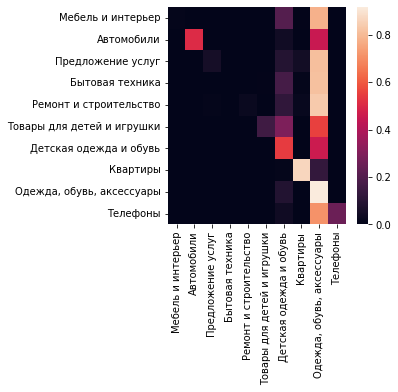

In [155]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_bow, xticklabels=metrics_bow.index.tolist()[:-1], 
            yticklabels=metrics_bow.index.tolist()[:-1])
plt.show()

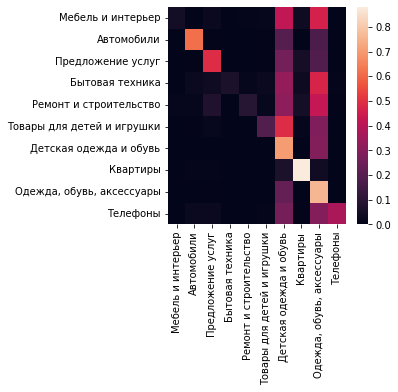

In [156]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

Давайте попробуем NMF (он работает дольше)

In [38]:

pipeline_nmf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])


In [39]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf)

In [40]:
metrics_nmf

precision  precision_std  recall  recall_std  \
Мебель и интерьер                0.80           0.02    0.16        0.03   
Автомобили                       0.90           0.03    0.75        0.05   
Предложение услуг                0.71           0.06    0.52        0.04   
Бытовая техника                  1.00           0.00    0.01        0.01   
Ремонт и строительство           0.69           0.20    0.03        0.01   
Товары для детей и игрушки       0.84           0.03    0.33        0.06   
Детская одежда и обувь           0.64           0.02    0.68        0.01   
Квартиры                         0.88           0.02    0.94        0.02   
Одежда, обувь, аксессуары        0.43           0.01    0.83        0.01   
Телефоны                         0.95           0.03    0.34        0.06   
mean                             0.78           0.04    0.46        0.03   

                              f1  f1_std  
Мебель и интерьер           0.27    0.04  
Автомобили                  0.82    0.02  
Предложение услуг           0.59    0.01  
Бытовая техника             0.03    0.01  
Ремонт и строительство      0.06    0.02  
Товары для детей и игрушки  0.47    0.07  
Детская одежда и обувь      0.66    0.01  
Квартиры                    0.91    0.02  
Одежда, обувь, аксессуары   0.56    0.01  
Телефоны                    0.50    0.07  
mean                        0.49    0.03

In [41]:
metrics_nmf - metrics_bow

precision  precision_std  recall  recall_std  \
Мебель и интерьер                0.13          -0.56    0.15        0.02   
Автомобили                       0.01           0.02    0.28        0.03   
Предложение услуг               -0.03          -0.03    0.43        0.02   
Бытовая техника                  0.33          -0.58    0.00        0.00   
Ремонт и строительство          -0.13           0.13   -0.01        0.00   
Товары для детей и игрушки       0.00          -0.05    0.17        0.05   
Детская одежда и обувь           0.15          -0.08    0.03       -0.08   
Квартиры                         0.07           0.00    0.04        0.01   
Одежда, обувь, аксессуары        0.03          -0.02    0.04       -0.10   
Телефоны                        -0.03           0.00    0.05       -0.01   
mean                             0.05          -0.12    0.12       -0.01   

                              f1  f1_std  
Мебель и интерьер           0.26    0.03  
Автомобили                  0.20    0.00  
Предложение услуг           0.42   -0.02  
Бытовая техника             0.01   -0.01  
Ремонт и строительство     -0.01    0.00  
Товары для детей и игрушки  0.21    0.05  
Детская одежда и обувь      0.11   -0.02  
Квартиры                    0.06    0.01  
Одежда, обувь, аксессуары   0.03    0.00  
Телефоны                    0.05   -0.01  
mean                        0.14    0.01

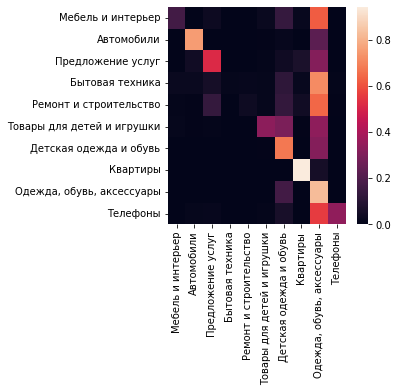

In [47]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_nmf.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

Понижение размерности не единственное для чего может пригодиться разложение матриц. 
Каждая из K размерностей в получившихся векторах соответствует группе семантически близких слов! То есть представление текста можно интерпретировать как тематическую характеристуку текста (и у каждой темы есть коэффициент). Эти темы подбираются под корпус и могут быть не очень интерпретируемы, но уже сам факт этого можно использовать. 

По векторам пропущенным через разложение лучше получается искать близкие тексты - так как косинусное расстояние в этом случае учитывает не только пересечение по словам, но и по темам. То есть можно найти похожий текст даже если в нем нет ни одного такого же слова, но есть синонимы.

Сравним поиск похожих текстов:

In [48]:
cv = CountVectorizer(tokenizer=lambda x: x.split(), min_df=5, max_df=0.1)
svd = TruncatedSVD(500)
X_sparse = cv.fit_transform(data['description_norm'])
X = svd.fit_transform(X_sparse)

Текст

In [49]:
data.loc[3, 'description']

'Автомобиль в отличном техническом состоянии. Одна хозяйка, оригинальная ПТС. Полный комплект ключей. ТО проходила вовремя. Салон чистый, не прокуренный. Музыка Пионер. Защита картера. Торг.'

Поиск после SVD

In [50]:
top_idx = cosine_distances(X[3].reshape(1, -1), X).argsort()[0,:5]
data.loc[top_idx, 'description'].values.tolist()

['Автомобиль в отличном техническом состоянии. Одна хозяйка, оригинальная ПТС. Полный комплект ключей. ТО проходила вовремя. Салон чистый, не прокуренный. Музыка Пионер. Защита картера. Торг.',
 'Автомобиль в отличном состоянии. Год выпуска 2012. Куплен в феврале 2013 года в салоне официального дилера. ПТС оригинал. Сервисная книжка с отметками о прохождении ТО. Полный комплект документов и ключей. Комплект зимней резины и ковриков. Комплектация на фото. В ДТП не участвовал.',
 'АВТОМОБИЛЬ ПО ОРИГИНАЛУ ПТС 2014г. ОДИН ВЛАДЕЛЕЦ! ОБСЛУЖАННЫЙ ПО РЕГЛАМЕНТУ! ПО ДВС, ТРАНСМИССИИ, ПОДВЕСКЕ НАРЕКАНИЙ НЕТ. ЧИСТЫЙ УХОЖЕННЫЙ САЛОН, КУЗОВ В ИДЕАЛЬНОМ СОСТОЯНИИ. ДВА КОМПЛЕКТА РЕЗИНЫ./\n/\nТОРГ ПРИ ОСМОТРЕ!/\nВОЗМОЖНО В КРЕДИТ!/\nДИАГНОСТИКА ПРИВЕТСТВУЕТСЯ!/\nЛЮБЫЕ ВАРИАНТЫ ОБМЕНА!',
 'Автомобиль в отличном техническом состоянии! Комфортный, семейный, экономичный автомобиль. Шустрый, маневренный, в салоне очень просторно. Бережная эксплуатация. Торг',
 'Hyundai Accent 2007 г.в /\n- Один хозяин! ПТС

Поиск до SVD

In [51]:
top_idx = cosine_distances(X_sparse[3].reshape(1, -1), X_sparse).argsort()[0,:5]
data.loc[top_idx, 'description'].values.tolist()

['Автомобиль в отличном техническом состоянии. Одна хозяйка, оригинальная ПТС. Полный комплект ключей. ТО проходила вовремя. Салон чистый, не прокуренный. Музыка Пионер. Защита картера. Торг.',
 'Автомобиль в отличном состоянии. Год выпуска 2012. Куплен в феврале 2013 года в салоне официального дилера. ПТС оригинал. Сервисная книжка с отметками о прохождении ТО. Полный комплект документов и ключей. Комплект зимней резины и ковриков. Комплектация на фото. В ДТП не участвовал.',
 'В отличном состоянии. Полный комплект.',
 'Состояние отличное,  полный комплект',
 'Mitsubishi Outlander 2012г.в. куплен у официального дилера в апреле 2013г., один собственник, пробег всего 65 000 км., все Т.О. проходил также в салоне у официального дилера, есть сервисная книга со всеми отметками. Автомобиль в отличном состоянии, не битый, не крашеный, оригинальный ПТС, полный комплект ключей./\nЮридическая чистота гарантируется./\nВозможна продажа в КРЕДИТ, ОБМЕН на ваш автомобиль.']

Часто хочется проанализировать полученные темы более детально и даже дать им названия. На основе таких тем можно сделать полезную продуктовую функцию (например, твиттер советует твиты по темам); категоризовать большую коллекцию документов для личного использования (например, разложить кучу научных статей по темам и читать только интересующую тему); или собрать или расширить тематические словари. 

Такой подробный анализ тем - отдельная большая задача, которая называется тематическим моделированием. Ее можно решать матричными разложениями, но в основном для этого используются специальные алгоритмы, самый популярный из которых - LDA.

# Тематическое моделирование

Для начала попробуем использовать матричные разложения, а потом сравним результат с LDA. 

И SVD и NMF помимо матрицы документы на темы строят матрицу слова на темы, которую можно проанализировать и понять, из каких слов состоят темы. Однако SVD использовать не удобно, т.к. значения в итоговых матрицах могут быть любыми (положительными, отрицательными, нулем, больше 1 по модулю) и не очень понятно, как использовать их в качестве принадлежности к определеной теме.

А вот NMF подходит отлично - значения в итоговых матрицах либо нулевые либо положительные. Можно интерпретировать это так - чем больше число, тем больше слово связано с темой. 

Возьмем более разнообразный корпус

In [158]:
texts = open('wiki_data.txt').read().splitlines()[:5000]
texts = ([normalize(text) for text in texts])

In [53]:
len(texts)

10000

Сделаем матрицу слова-документы с помощью TfidfVectorizer

In [54]:
vectorizer = TfidfVectorizer(max_features=2000, min_df=10, max_df=0.4)
X = vectorizer.fit_transform(texts)

Разложим её.

In [71]:
model = NMF(50)

In [72]:
model.fit(X)

NMF(n_components=50)

Вытащим словарь, по которому мы построили модель.

In [73]:
feat_names = vectorizer.get_feature_names()

Теперь посмотрим на матрицу темы-слова (она лежит в model.components_), отсортируем её по строкам (т.е. внутри каждого вектора темы упорядочим слова по убыванию) и возьмем топ N слов, сопоставив индексы со словарём

In [74]:
top_words = model.components_.argsort()[:,:-5:-1]

for i in range(top_words.shape[0]):
    words = [feat_names[j] for j in top_words[i]]
    print(i, "--".join(words))

0 житомирский--код--область--ул
1 олимпийский--летний--игра--медаль
2 для--или--мочь--не
3 сесть--харьковский--расстояние--километр
4 сантиметр--длина--мм--или
5 хутор--ростовский--район--поселение
6 клуб--матч--лига--сезон
7 армия--дивизия--война--генерал
8 значение--означать--термин--мочь
9 остров--километр--расположить--относиться
10 альбом--группа--песня--the
11 уезд--округ--городской--губерния
12 он--что--свой--не
13 зимний--олимпийский--игра--медаль
14 населить--пункт--название--россия
15 новоград--волынский--житомирский--область
16 ссср--иван--москва--советский
17 фильм--режиссёр--роль--американский
18 город--население--центр--расположить
19 чемпионат--команда--мир--сезон
20 улица--переулок--дом--лицо
21 емильчинский--житомирский--код--область
22 овручский--житомирский--код--область
23 фамилия--носитель--известный--русский
24 род--семейство--подсемейство--входить
25 церковь--святой--храм--собор
26 малинский--житомирский--код--область
27 посёлок--километр--дорога--район
28 хороше

У разложения есть метрика, показывающая насколько хорошо восстанавливается изначальная матрица. Чем меньше, тем лучше.

In [75]:
model.reconstruction_err_

79.16688298813138

LDA есть в sklearn и оно работает также как и NMF

In [76]:
model = LatentDirichletAllocation(50)

In [77]:
model.fit(X)

LatentDirichletAllocation(n_components=50)

In [78]:
feat_names = vectorizer.get_feature_names()

In [79]:
top_words = model.components_.argsort()[:,:-5:-1]

for i in range(top_words.shape[0]):
    words = [feat_names[j] for j in top_words[i]]
    print(i, "--".join(words))

0 клуб--чемпионат--матч--турнир
1 сесть--харьковский--километр--село
2 уезд--округ--городской--специальный
3 коммуна--литовский--норвегия--относиться
4 корабль--флот--морской--японский
5 команда--персонаж--построить--чемпионат
6 зимний--олимпийский--игра--завоевать
7 автомобиль--двигатель--трасса--разряд
8 он--что--для--который
9 поселение--сельсовет--сельский--деревня
10 ван--вершина--численность--гора
11 житомирский--область--код--сесть
12 суд--верховный--приход--судья
13 1965--федерация--суд--общий
14 улица--переулок--слава--дата
15 событие--представить--ниже--научный
16 означать--мочь--николай--пространство
17 привести--список--ниже--учебный
18 фамилия--носитель--известный--женский
19 хутор--ростовский--поселение--сельский
20 танец--ссср--спорт--мастер
21 район--крым--крымский--состав
22 100--джон--договор--корея
23 армия--дивизия--генерал--командир
24 список--мост--вод--природный
25 знамя--японский--или--известный
26 олимпийский--игра--летний--медаль
27 альбом--группа--песня--the


Но для LDA лучше использовать gensim. Он лучше работает с большими корпусами и в нем есть специальные метрики для тематического моделирования

## Gensim

Интерфейс в gensim немного отличается 

В начале нужно также построить словарь и создать разреженное представление каждого документа. Gensim принимает на вход уже токенизированные тексты (списком списков). Так как он изначально настроен на работу с большими данными, можно использовать генераторы.

In [165]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

Фильтруем редкие и частые слова также как в sklearn

In [65]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [66]:
print(dictinary)

Dictionary(12941 unique tokens: ['1,2', '1,5', '12', '12,5', '14']...)


Преобразуем наши тексты в мешки слов. 

In [67]:
corpus = [dictinary.doc2bow(text.split()) for text in texts]

После этого уже можно обучать модель. LDA (Latent Dirichle Allocation) или латентное размещение Дирихле - это достаточно сложная вероятностная модель, которая основана на распределении Дирихле. Если вам интересно разобраться подробнее, то вот несколько ссылок - [оригинальная статья 2003 года от David Blei](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), [видео от David Blei](https://www.youtube.com/watch?v=FkckgwMHP2s), [лекция по тематическому моделированию на русском](https://www.youtube.com/watch?v=44-0WBDqtRk)

Если сильно упростить, то LDA строит двойное распределение (документы на темы и темы на слова). Это очень похоже на матричные разложения (те же две матрицы с такими же размерностями), но тут значения будут честными вероятностями и обучается это все по-другому. Интуитивная идея такая - с помощью такого двойного распределения должно получаться сгенерировать мешки слов для документов в корпусе. Процесс генерации выглядит так - для документа из построенного распределения по темам выбирается тема, а затем для выбранной темы из построенного распределения по словам выбирается слово. Очень похоже на то как мы генерировали текст в прошлом занятии, но на двух уровнях и без последовательностей.

Про параметры можно почитать в документации:

In [129]:
?gensim.models.LdaModel

Основные это num_topics, alpha, eta и passes. 

**num_topics** - это количество тем. Это основной параметр и настраивать его проще всего. Обычно 200 оптимальное значение. Можно поставить поменьше, если тексты не очень разнообразные или хочется уменьшить время обучения.

**alpha** и **eta** - параметры, которые влияют на разреженность распределения документы-темы и темы-слова. Разреженность в данном случае означает, что вероятности будут ненулевыми только у небольшого количества тем/слов, т.е. модель будет стремиться приписать документу минимальное количество тем, а темы сделать максимально непохожими друг на друга (слово между ними не будут пересекаться). У
alpha есть значения "asymmetric" и "auto", которые можно попробовать (по умолчанию стоит "symmetric", т.е. не разреженное). Eta можно задать каким-то числом или самому сделать изначальное распределение слов по темам. НО настраивать эти параметры сложно и непонятно, и вообще лучше надеяться, что по умолчанию все заработает.

**passes** - задает количество проходов по данным. Чем больше, тем лучше сойдется модель, но обучаться будет дольше.

In [80]:
lda = gensim.models.LdaMulticore(corpus, 
                                 100, # колиество тем
                                 alpha='asymmetric',
                                 id2word=dictinary, 
                                 passes=10) 
# если не поддерживается многопоточность
# lda = gensim.models.LdaModel(200, id2word=dictinary, passes=5)

Посмотрим на топики.

In [81]:
lda.print_topics()

[(97,
  '0.027*"крым" + 0.021*"крымский" + 0.012*"двор" + 0.011*"симферопольский" + 0.010*"житель" + 0.010*"согласно" + 0.009*"деревня" + 0.008*"республика" + 0.008*"числиться" + 0.007*"таврический"'),
 (98,
  '0.018*"социальный" + 0.014*"обеспечение" + 0.006*"выставка" + 0.005*"создать" + 0.004*"волосок" + 0.004*"современный" + 0.004*"фестиваль" + 0.004*"нью-йорк" + 0.004*"пенсия" + 0.004*"система"'),
 (99,
  '0.026*"филип" + 0.014*"бой" + 0.008*"праздник" + 0.007*"тепловоз" + 0.006*"я" + 0.006*"раунд" + 0.006*"эфиопия" + 0.006*"удар" + 0.005*"боец" + 0.004*"нога"'),
 (96,
  '0.024*"ссср" + 0.017*"флот" + 0.017*"корабль" + 0.011*"советский" + 0.010*"эсминец" + 0.009*"вмф" + 0.007*"военно-морской" + 0.006*"апрель" + 0.006*"подводный" + 0.006*"морской"'),
 (95,
  '0.033*"фильм" + 0.018*"роль" + 0.009*"сериал" + 0.008*"режиссёр" + 0.007*"актёр" + 0.005*"актриса" + 0.005*"главный" + 0.005*"жизнь" + 0.005*"американский" + 0.004*"хороший"'),
 (94,
  '0.020*"майя" + 0.014*"стадион" + 0.009*"

Ещё есть штука для визуализации.

In [82]:
pyLDAvis.enable_notebook()

In [83]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictinary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
64     0.128232  0.087089       1        1  4.717424
27     0.207625  0.023357       2        1  4.622208
19     0.096334 -0.073465       3        1  4.129338
40    -0.007476 -0.101943       4        1  3.890668
95     0.057133 -0.180346       5        1  3.490199
...         ...       ...     ...      ...       ...
37    -0.029826 -0.008810      96        1  0.205733
33     0.015260 -0.004193      97        1  0.202748
87     0.026206 -0.073557      98        1  0.190181
94     0.014558 -0.040111      99        1  0.167581
71     0.032593 -0.025194     100        1  0.124622

[100 rows x 5 columns], topic_info=           Term         Freq        Total  Category  logprob  loglift
788        уезд  1987.000000  1987.000000   Default  30.0000  30.0000
128      остров  1744.000000  1744.000000   Default  29.0000  29.0000
3772     летний  1406.000000  1406.000000   Default  28.0000  28.0000
74         река  1907.000000  1907.000000   Default  27.0000  27.0000
47     километр  2043.000000  2043.000000   Default  26.0000  26.0000
...         ...          ...          ...       ...      ...      ...
1867     первое     6.704627  1395.033515  Topic100  -5.4828   1.3498
1358        май     6.516893  1663.573802  Topic100  -5.5112   1.1453
402   последний     5.596300  1451.230307  Topic100  -5.6635   1.1296
2386     машина     5.075115   427.037035  Topic100  -5.7613   2.2551
620       около     5.225886  1469.113538  Topic100  -5.7320   1.0489

[5939 rows x 6 columns], token_table=      Topic      Freq Term
term                      
792       3  0.581680    0
792       9  0.011258    0
792      10  0.003753    0
792      14  0.030022    0
792      16  0.026269    0
...     ...       ...  ...
610      93  0.027607    №
610      94  0.001904    №
610      96  0.001904    №
610      98  0.003808    №
610      99  0.002856    №

[82156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[65, 28, 20, 41, 96, 55, 93, 3, 57, 47, 24, 89, 90, 84, 12, 5, 45, 1, 61, 16, 10, 76, 22, 13, 70, 59, 87, 75, 8, 82, 51, 46, 62, 23, 91, 71, 85, 52, 48, 39, 11, 74, 66, 18, 63, 32, 27, 54, 98, 94, 36, 2, 6, 97, 81, 21, 77, 79, 73, 14, 69, 42, 17, 60, 33, 56, 19, 35, 68, 44, 86, 31, 99, 50, 64, 58, 15, 100, 67, 26, 49, 83, 80, 7, 9, 4, 53, 25, 40, 30, 29, 78, 37, 92, 43, 38, 34, 88, 95, 72])

На графике должно быть как можно меньше пересекающихся кружков (т.е. темы состоят из разных слов), а сами кружки не должны быть огромными (скорее всего такую тему можно разбить на несколько поменьше).

Можно посмотреть метрики.

In [84]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

85781.2479792694

Перплексия показывает насколько хороше моделируется корпус. Чем ближе к нулю, тем лучше. Можно использовать, чтобы настраивать количество проходов по корпусу (когда перестало улучшаться, то можно останавливаться).

Ещё есть когерентность. Она численно оценивает качество тем (проверяется, что темы состоят из разных слов и что в теме есть топ тематических слов). 

Чем выше, тем лучше.

In [85]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [86]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [87]:
coherence_model_lda.get_coherence()

0.5402683798751431

Но все эти числа вспомогательны! Главные критерии качества модели: интерпретируемость и понятность тем (т.е. нужно глазами смотреть на каждую тему), а также польза для практической задачи, которую вы пытаетесь решить.